# Analysis of Per-shot Decoding

*Want to follow along? {nb-download}`Download this notebook.<shot_analysis.ipynb>`*

In this notebook, we show how you may analyse decoding performance on a per-shot basis. Firstly, we will simulate a quantum memory experiment with the repetition code.
Secondly, we will extract a particular shot which led to a decoder failure. And lastly, we will visualise detectors which lit up in this failure event.

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import stim
from deltakit.explorer import Client, enums, types

client = Client.get_instance()

## Generate

Here, we generate a quantum **Z**-memory experiment using the distance-7 repetition code with 5 rounds, and then we add noise to it.

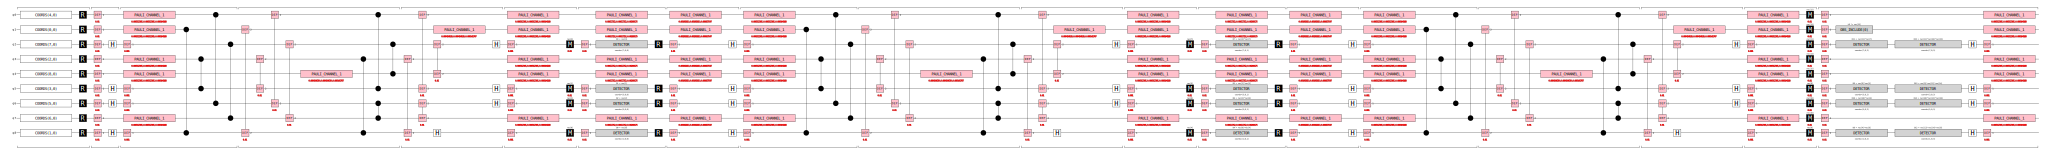

In [2]:
compiled_circuit = client.generate_circuit(
    types.QECExperimentDefinition.get_repetition_z_quantum_memory(
        distance=5,
        num_rounds=3,
        basis_gates=["CZ", "H", "MZ", "RZ"],
    )
)

noise_model = types.PhysicalNoiseModel.get_superconducting_noise()

noisy_circuit = client.add_noise(
    stim_circuit=compiled_circuit,
    noise_model=noise_model,
)

stim.Circuit(noisy_circuit).diagram('timeline-svg')

## Simulate

Here, we simulate the circuit 10000 times and save detectors and observables together with measurements in the text 01 format.

In [3]:
measurements, _ = client.simulate_stim_circuit(
    stim_circuit=noisy_circuit,
    shots=10000,
)

detectors, observables = measurements.to_detectors_and_observables(
    stim_circuit=noisy_circuit,
)

## Decode

Here, we use the method `Client.decode`, which decodes the detector outcomes. We pass an optional `result_file` parameter, which specifies where the observable predictions should be saved. This file has the same structure as the observables file. For a quantum memory experiment which starts from the `|0⟩` state, the number of decoder failures may be computed as the number of mismatches between predictions file and observables files.

In [4]:
decoding_result = client.decode(
    detectors=detectors,
    observables=observables,
    decoder=types.Decoder(decoder_type=enums.DecoderType.AC, parallel_jobs=4),
    noisy_stim_circuit=noisy_circuit,
)

## Obtain an example failure and success

In this loop, we iterate through the detectors, observables and predictions files together. If the prediction and observable values for a given shot disagree, this corresponding syndrome is saved as `fail_syndrome`, and gives an example of where the decoder failed. If prediction and observable agree, this is a successful decoding shot, and the syndrome is saved as `success_syndrome`. We break from the loop when we have examples for both successful and failed decoding.

In [5]:
fail_syndrome = None
success_syndrome = None

for pred, obs, det in zip(
       decoding_result.predictions.as_numpy(), observables.as_numpy(), detectors.as_numpy()
):
    syndrome = [i for i, bit in enumerate(det) if bit == 1]
    result =  {"detectors": det, "observable": obs, "prediction": pred, "syndrome": syndrome}
    if pred != obs:  # If prediction and observable disagree
        fail_syndrome = syndrome
        fail_result = result
    else:
        success_syndrome = syndrome
        success_result = result

    # Once we have instances of fail and success syndromes, we break out of the loop
    if fail_syndrome and success_syndrome:
        break

assert fail_syndrome, "Decoder did not fail to decode any syndrome. Please increase the noise and/or the number of shots to obtain a decoding failure example."
assert success_syndrome, "Decoder did not successfully decode any syndrome. Please reduce the noise and/or increase the number of shots to obtain a decoding success example."

## Visualise

Here, we plot the repetition code detectors (X axis) over time (Y axis) for the failure and success cases found above. Orange nodes correspond to detectors that "lit up". This type of plot is know as decoding graph, and it is useful to analyse and debug decoder behaviour.

Each node in the decoding graph corresponds to a detector and each edge corresponds to a potential error location. The detectors a particular error "light up" are those at either end of the corresponding edge. The graph can be constructed from the detector error model. Each detector has an associated coordinate. In this plot, the coordinates have the form `(X, Time)`, where `X` is the location of the auxiliary qubit associated with the stabiliser whose measurements form the detector. 

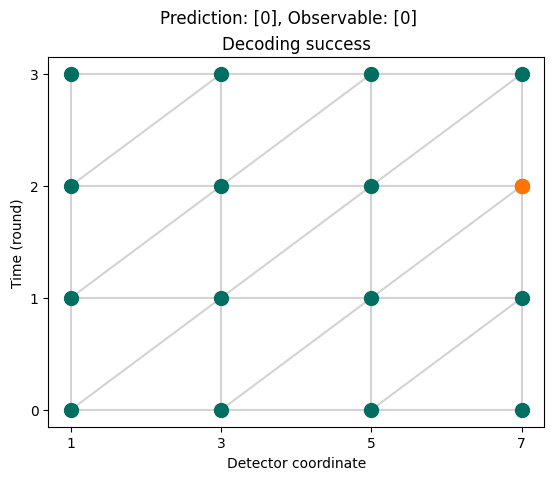

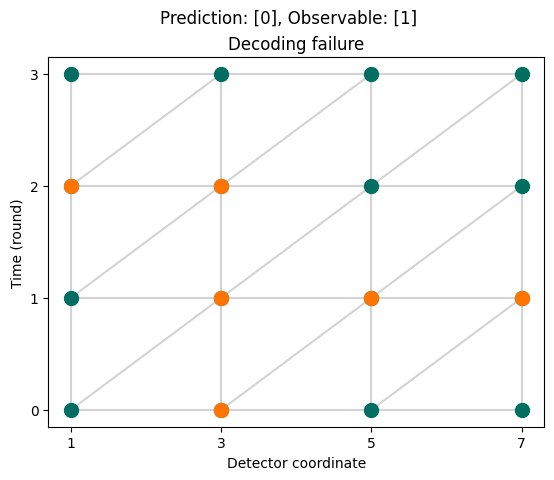

In [6]:
circuit = stim.Circuit(noisy_circuit)

def plot_decoding_graph(result, title):
    syndrome = result['syndrome']

    detector_coordinates = circuit.get_detector_coordinates()  # Get the coords of detectors
    nodes = np.array(list(detector_coordinates.values()))
    syndrome_nodes = nodes[syndrome, :]  # Syndrome nodes (we will colour these orange)

    dem = circuit.detector_error_model().flattened()
    node_pairs = [
        instruction.targets_copy() for instruction in dem
        if instruction.type == "error" and len(instruction.targets_copy()) == 2
    ]  # Pick out errors that arise from pairs of detectors firing
    edges = np.array([
        [detector_coordinates[detector.val] for detector in pair]
        for pair in node_pairs
        if pair[0].is_relative_detector_id() and pair[1].is_relative_detector_id()
    ])  # The coords of our edges, these correspond to places where errors can occur (we will colour these grey)

    # Plotting
    for start, end in edges:
        plt.plot(
            [start[0], end[0]], [start[-1], end[-1]],
            color="lightgray", zorder=-1)  # Plot the edges

    plt.scatter(nodes[:,0], nodes[:,-1], s=100, c='#006F62')  # Plot all the detectors in blue
    plt.scatter(syndrome_nodes[:,0], syndrome_nodes[:,-1], s=100, c='#FF7500')  # Colour the detectors that lit up in orange
    plt.xticks(list(set(nodes[:,0])))  # Set the x-axis scale
    plt.yticks(list(set(nodes[:,-1])))  # Set the y-axis scale
    plt.grid(False)
    plt.xlabel("Detector coordinate")
    plt.ylabel("Time (round)")
    plt.title(title)
    plt.suptitle(f"Prediction: {result['prediction']}, Observable: {result['observable']}")
    plt.show()

plot_decoding_graph(success_result, title="Decoding success")
plot_decoding_graph(fail_result, title="Decoding failure")